# A Qualitative Evaluation of User-perceived Satisfaction with Wikipedia Article Recommendations

This notebook contains all the code for generating the tables and figures of our paper.

To run this notebook, you need to download the following files from our repository into the `./data/` directory: `questions.csv`, `answers.csv`, `user_details.csv`, `articles.csv`, `categories.csv`. 




In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.patheffects as path_effects

import matplotlib.patches as mpatches

from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from collections import defaultdict

import seaborn as sns
sns.set()

def get_value_mapping(qs, qid):
    return {-2+i: a.strip() for i, a in enumerate(qs[qs['mc_qid'] == qid]['answers'].values[0].split('/'))}

figures_dir = './figures/2'
data_dir = './data'

# read data from CSVs
qs = pd.read_csv(data_dir + '/questions.csv', delimiter=';')
user_df = pd.read_csv(data_dir + '/user_details.csv', delimiter=';')
raw_df = pd.read_csv(data_dir + '/answers.csv', skip_blank_lines=True)

adf = pd.read_csv(data_dir + '/articles.csv')
cdf = pd.read_csv(data_dir + '/categories.csv')

# sanity checks
assert len(raw_df) == 80
assert np.array(raw_df['PID'].value_counts().values == 4).sum() == 20. # each participant needs 4 articles
assert np.array(raw_df['Article Name'].value_counts().values == 2).sum() == 40  # each article needs 2 answers

In [2]:
# group mapping
g2_cols_from = ['A1', 'B1', 'MC3', 'MC4', 'MC A1.1', 'MC A1.2', 'MC A1.3', 'MC A1.4', 'MC A1.5', 'MC A1.6', 'MC A1.7', 'MC B1.1', 'MC B1.2', 'MC B1.3', 'MC B1.4', 'MC B1.5', 'MC B1.6', 'MC B1.7']
g2_cols_to =   ['B1', 'A1', 'MC4', 'MC3', 'MC B1.1', 'MC B1.2', 'MC B1.3', 'MC B1.4', 'MC B1.5', 'MC B1.6', 'MC B1.7', 'MC A1.1', 'MC A1.2', 'MC A1.3', 'MC A1.4', 'MC A1.5', 'MC A1.6', 'MC A1.7']

rows = []
for idx, row in raw_df.iterrows():
    if row['GID'] == 2:
        original_row = row.copy()
        
        for col_idx, col in enumerate(g2_cols_from):
            new_col = g2_cols_to[col_idx]            
            row[new_col] = original_row[col]
    rows.append(row)
    
df = pd.DataFrame(rows)

In [3]:
# display some data

# questions
with pd.option_context('display.max_colwidth', 220):
    display(qs)
    
# users
display(user_df.head())

# answers
display(df.head())

,mc_qid,question,answers
0,A1,Would you say the recommended articles are more similar or more diverse when compared to the article at hand?,similar/diverse/uncertain
1,B1,Would you say the recommended articles are more similar or more diverse when compared to the article at hand?,yes/no
2,A2,"Is there a surprising recommendation, i.e. an unexpected recommendation among the recommendation Set A?",yes/no
3,B2,"Is there a surprising recommendation, i.e. an unexpected recommendation among the recommendation Set A?",yes/no
4,MC1,How familiar were you with the topic of the article? (i.e. did you have any background knowledge on the topic?),Not at all/unfamiliar/undecided/familiar/very familiar
5,MC2,How interesting did you find the source article?,Not at all interesting/uninteresting/ undecided/interesting/ very interesting
6,MC3,How likely are you to click on a recommendation made in the recommended article Set A?,very unlikely/unlikely/undecided/likely/very likely
7,MC4,How likely are you to click on a recommendation made in the recommended article Set B?,very unlikely/unlikely/undecided/likely/ very likely
8,MC A1.1,The articles recommended to me matched the content of the article.,strongly disagree/disagree/undecided/agree/strongly agree
9,MC B1.1,The articles recommended to me matched the content of the article.,strongly disagree/disagree/undecided/agree/strongly agree


,PID,Group ID,Field of study,Education level,Age,Familiar with Wikipedia?,Hrs/M on Wikipedia,Reason #1,Reason #2,Reason #3,Optional reasons
0,1,2,Information Engineering,Schweizerische Maturität,NaN,Y,2.0,look up a definition,research a topic,-,-
1,2,1,Computer Science,Abitur,21.0,Y,10.0,Look up definitions/algorithms,Look up chemical values and constants,Expand general knowledge,NaN
2,3,2,Information Engineering,Abitur,23.0,Y,1.0,Research,Interest in specific topic,NaN,NaN
3,4,1,-,High School,37.0,Y,2.0,Information about a specific topic,Entertainment – just skipping through articles,I like to compare articles in different languages,NaN
4,5,2,Nanoplasmonics,Diploma,31.0,Y,10.0,Look something up (something special),Get general information on a topic,Re-linked there,NaN


,PID,GID,Article Name,A1,A1.1,A2,A3,B1,B1.1,B2,...,MC A1.5,MC A1.6,MC A1.7,MC B1.1,MC B1.2,MC B1.3,MC B1.4,MC B1.5,MC B1.6,MC B1.7
0,1,2,Babylonian mathematics,similar,(They) branch out into different directions,Y,Friction. Not directly related to gravity to m...,diverse,They seem to focus mostly on certain special f...,N,...,1,-1,1,-1,2,1,-2,2,-1,2
1,1,2,Fire,similar,They focus on subjects which are not really re...,Y,"2, 4, 6, 7, 8 (Accident, Atmosphere of Earth, ...",diverse,They seem to focus on subjects directly relate...,N,...,1,1,1,-2,-1,2,-2,-1,-2,-1
2,1,2,Mainau,similar,They branch out in some different directions,Y,Teutonic order. I don't know of any connection...,diverse,Most of them are about people,Y,...,0,1,-1,0,1,1,-1,1,0,1
3,1,2,Albert Einstein,diverse,They feature some related people as well as ot...,Y,Sigmund Freud. I don't see any connection,diverse,Same as in A. They feature some related people...,Y,...,1,-1,1,1,2,1,-1,2,-1,2
4,2,1,Babylonian mathematics,diverse,The terms are about mathematics/astronomy in v...,Y,Plimpton 322 is a special term while the rest ...,similar,The terms all occur in the article and are clo...,N,...,1,-1,1,2,-1,-1,1,-1,1,-1


In [4]:
# join articles + categories
acdf = adf.set_index('category').join(cdf.set_index('id'))

# all to lower
acdf['article'].apply(lambda s: s.lower())
df['Article Name'].apply(lambda s: s.lower())

# join answers + article properties
xdf = df.set_index('Article Name').join(acdf.set_index('article'))
xdf.head()

,PID,GID,A1,A1.1,A2,A3,B1,B1.1,B2,B3,...,MC B1.5,MC B1.6,MC B1.7,id,words,page_views,quality,category_name,pop_type,topic_type
AC/DC,17,2,diverse,"Appear more similar, because they stay on the ...",N,-,similar,More diverse because they are about different ...,N,-,...,0,1,0,39,"10,442","2,780,873",FA,Popular named entities,popular,named entity
AC/DC,18,1,similar,"different rock bands and genre, plus a band me...",Y,Hard rock,similar,"about the band but about songs, albums, band m...",N,-,...,0,1,0,39,"10,442","2,780,873",FA,Popular named entities,popular,named entity
ARD (broadcaster),15,2,diverse,-,Y,History of Südwestrundfunk,uncertain,Because ir recommends other TV broadcaster and...,N,-,...,-1,1,-2,28,"2,397","78,941",S,"Niche named entities (actors, politicians, loc...",niche,named entity
ARD (broadcaster),16,1,diverse,Different broadcaster and also Germany as the ...,N,-,similar,Mostly the same names (Rundfunk) appears in al...,N,-,...,0,1,0,28,"2,397","78,941",S,"Niche named entities (actors, politicians, loc...",niche,named entity
Albert Einstein,1,2,diverse,They feature some related people as well as ot...,Y,Sigmund Freud. I don't see any connection,diverse,Same as in A. They feature some related people...,Y,Pantur Silaban. Never heard this name.,...,2,-1,2,31,"15,071","9,426,364",GA,Popular named entities,popular,named entity


## Figures

,similar,diverse,uncertain
MLT,63,14,3
CPA,25,53,2


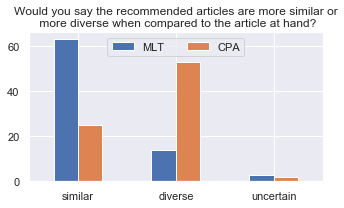

In [5]:
graph_df = df['B1'].value_counts().rename('MLT').to_frame()\
               .join(df['A1'].value_counts().rename('CPA').to_frame())

ax = graph_df.plot(
    kind='bar', 
    figsize=(5, 3), # igsize=(6, 3), 
    title='Would you say the recommended articles are more similar or\n more diverse when compared to the article at hand?'
)
ax.set_xticklabels(get_value_mapping(qs, 'A1').values(), rotation=0)

#
plt.legend(graph_df.columns, ncol=2, loc='upper center', #bbox_to_anchor=(0.5, -0.85)
          )

    
display(graph_df.transpose())

plt.tight_layout()
plt.savefig(figures_dir + f'/a1_b1_diverse-similar.svg')
plt.savefig(figures_dir + f'/a1_b1_diverse-similar.pdf')

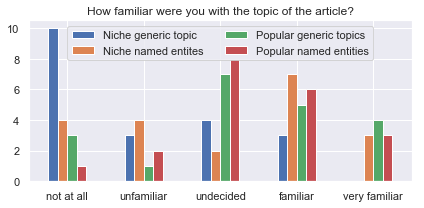

In [6]:
# Familiar depending on article category

# NOTE: Niche named entities weren't as "niche" as we expected.

# topic_type, pop_type, 
qid = 'MC1'
for cat_group in ['category_name', 'topic_type', 'pop_type']:
    graph_df = xdf.groupby([qid, cat_group]).size().unstack(fill_value=0)
    ax = graph_df.plot(
        kind='bar', 
        figsize=(6, 3), 
        title='How familiar were you with the topic of the article?',
        rot=90,
        #colors=['blue', 'darkblue', 'red', 'darkred'],
        #ylabel='',
    )
    ax.set_xticklabels(['not at all', 'unfamiliar', 'undecided', 'familiar', 'very familiar'], rotation=0) # get_value_mapping(qs, qid).values())
    ax.legend([
        'Niche generic topic', 
        'Niche named entites', 
        'Popular generic topics', 
        'Popular named entities'], 
        #loc='lower center', 
        loc='upper center', 
        ncol=2, 
        #bbox_to_anchor=(0.5,-0.8)
    )
    ax.set_xlabel(None)
    fig = ax.get_figure()
    fig.tight_layout()
    
    #fig.savefig('./figures/mc1_how-familiar-were-you.svg')
    fig.savefig(figures_dir + '/mc1_how-familiar-were-you.pdf')
    break
    

In [7]:
# Prepare data

cols = ['MC A1.5', 'MC B1.5', 'MC A1.6', 'MC B1.6']
cols = qs[qs['answers'] == 'strongly disagree/disagree/undecided/agree/strongly agree']['mc_qid']

category_names = get_value_mapping(qs, 'MC A1.1').values()

results_a = defaultdict(list)
results_b = defaultdict(list)

value_keys = get_value_mapping(qs, 'MC A1.1').keys()
for c in cols:
    for v in value_keys:
        if 'A' in c:
            results_a[c].append((df[c] == v).sum())
        if 'B' in c:
            results_b[c].append((df[c] == v).sum())
            
results_a

defaultdict(list,
            {'MC A1.1': [5, 26, 19, 19, 11],
             'MC A1.2': [5, 19, 19, 27, 10],
             'MC A1.3': [9, 11, 14, 33, 13],
             'MC A1.4': [18, 28, 14, 11, 9],
             'MC A1.5': [7, 13, 24, 27, 9],
             'MC A1.6': [7, 22, 22, 20, 9],
             'MC A1.7': [5, 18, 17, 30, 10]})

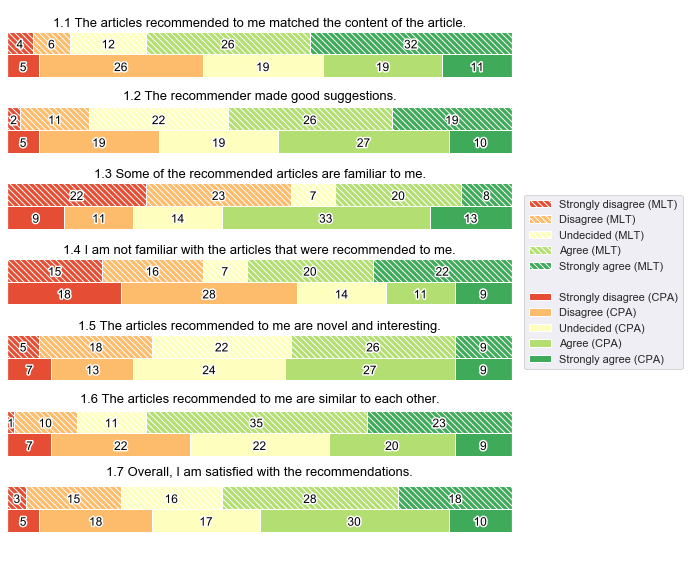

In [9]:
# Survey plot

labels = [
    '1.1 The articles recommended to me matched the content of the article.', 
    '1.2 The recommender made good suggestions.', 
    '1.3 Some of the recommended articles are familiar to me.', 
    '1.4 I am not familiar with the articles that were recommended to me.', 
    '1.5 The articles recommended to me are novel and interesting.', 
    '1.6 The articles recommended to me are similar to each other.', 
    '1.7 Overall, I am satisfied with the recommendations.',    
]

matplotlib.rcParams.update({'font.size': 12})

text_color = 'black' 

bar_text_args = dict(
    ha='center', va='center', 
    color=text_color, 
    #fontsize='x-large',
    path_effects=[path_effects.withStroke(linewidth=3, foreground='w')]
)

data_a = np.array(list(results_a.values()))
data_a_cum = data_a.cumsum(axis=1)

data_b = np.array(list(results_b.values()))
data_b_cum = data_b.cumsum(axis=1)


bar_height = 0.3 #0.3

category_colors_a = plt.get_cmap('RdYlGn')(
    np.linspace(0.15, 0.85, data_a.shape[1]))
category_colors_b = plt.get_cmap('RdYlGn')(
    np.linspace(0.15, 0.85, data_b.shape[1]))

#fig, ax = plt.subplots(figsize=(8, 10))
fig, ax = plt.subplots(figsize=(10, 8))

#fig, ax = plt.subplots(figsize=(12, 10))

ys = 1 * np.arange(len(labels))    # the y locations for the groups

for i, (colname, color_a, color_b) in enumerate(zip(category_names, category_colors_a, category_colors_b)):
    widths_a = data_a[:, i][::-1]
    starts_a = data_a_cum[:, i][::-1] - widths_a
    
    # cpa
    ax.barh(ys, widths_a, left=starts_a, height=bar_height,
            label=colname, color=color_a)

    # mlt
    widths_b = data_b[:, i][::-1]
    starts_b = data_b_cum[:, i][::-1] - widths_b
    #color_b[3] = 0.5 
    bar = ax.barh(ys+bar_height, widths_b, left=starts_b, height=bar_height,
            label=colname, color=color_b, hatch=r'\\\\')    
    #bar.set_hatch('-')
    
    xcenters_a = starts_a + widths_a / 2
    xcenters_b = starts_b + widths_b / 2
    
    r, g, b, _ = color_a
    text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
    text_color = 'black'
    
    for y_i, (x, c) in enumerate(zip(xcenters_a, widths_a)):
        if c > 0:
            ax.text(x, ys[y_i] - 0.03, str(int(c)), **bar_text_args)
        
    for y_i, (x, c) in enumerate(zip(xcenters_b, widths_b)):
        if c > 0:
            ax.text(x, ys[y_i]+bar_height - 0.03, str(int(c)), **bar_text_args)

# y-axis as labels (left aligend)
#ax.set_yticks(ys + bar_height / 2)  # vertial center
#ax.set_yticklabels(labels, ha = 'left')
#ax.invert_yaxis()

# manual labels in center
label_text_args = dict(color='black', size=13, ha='center', va='center', transform=ax.transAxes)
#ax.text(0.5, 1, labels[0], color='black', ha='center', va='center', transform=ax.transAxes)

ax.text(0.5, 1 * 1./len(labels) + 0.01, labels[-1], **label_text_args)
ax.text(0.5, 2 * 1./len(labels) - 0.00, labels[-2], **label_text_args)
ax.text(0.5, 3 * 1./len(labels) - 0.01, labels[-3], **label_text_args)
ax.text(0.5, 4 * 1./len(labels) - 0.015, labels[-4], **label_text_args)
ax.text(0.5, 5 * 1./len(labels) - 0.02, labels[-5], **label_text_args)
ax.text(0.5, 6 * 1./len(labels) - 0.02, labels[-6], **label_text_args)
ax.text(0.5, 7 * 1./len(labels) - 0.03, labels[-7], **label_text_args)

ax.yaxis.set_visible(False)

ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(data_a, axis=1).max())

fig.patch.set_alpha(1)
ax.patch.set_alpha(1)
ax.patch.set_facecolor('white')

circs = []

for i, cat in enumerate(['Strongly disagree', 'Disagree','Undecided', 'Agree', 'Strongly agree']):
    circs.append(mpatches.Patch(facecolor=category_colors_a[i],hatch=r'\\\\',label=cat + ' (MLT)'))

circs.append(
    matplotlib.lines.Line2D([],[],linestyle='')
)
    
for i, cat in enumerate(['Strongly disagree', 'Disagree','Undecided', 'Agree', 'Strongly agree']):
    circs.append(mpatches.Patch(facecolor=category_colors_a[i],label=cat + ' (CPA)'))

#ax.legend(handles=circs,ncol=2,loc='lower center',bbox_to_anchor=(0.5,-0.1)) # , fontsize='small'
#ax.legend(handles=circs,ncol=5, loc='lower center',bbox_to_anchor=(0.5,-0.05)) # , fontsize='small'
ax.legend(handles=circs,ncol=1, loc='right', bbox_to_anchor=(1.35,0.5)) # , fontsize='small'

yax = ax.get_yaxis()
yax.set_tick_params(pad=110)

plt.tight_layout()
plt.savefig(figures_dir + '/mc_results1-7.pdf')
plt.savefig(figures_dir + '/mc_results1-7.svg')

plt.show()

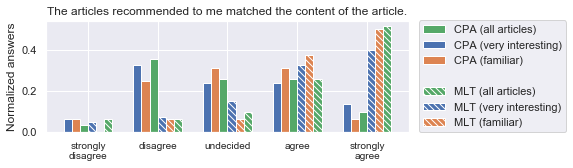

,-2,-1,0,1,2
CPA,5.0,26.0,19.0,19.0,11.0
MLT,4.0,6.0,12.0,26.0,32.0
CPA (very interesting seed),1.0,4.0,5.0,5.0,1.0
MLT (very interesting seed),0.0,1.0,1.0,6.0,8.0
CPA (familiar seed),1.0,11.0,8.0,8.0,3.0
MLT (familiar seed),2.0,2.0,3.0,8.0,16.0


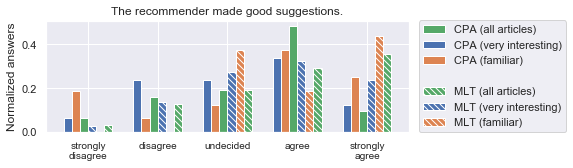

,-2,-1,0,1,2
CPA,5.0,19.0,19.0,27.0,10.0
MLT,2.0,11.0,22.0,26.0,19.0
CPA (very interesting seed),3.0,1.0,2.0,6.0,4.0
MLT (very interesting seed),0.0,0.0,6.0,3.0,7.0
CPA (familiar seed),2.0,5.0,6.0,15.0,3.0
MLT (familiar seed),1.0,4.0,6.0,9.0,11.0


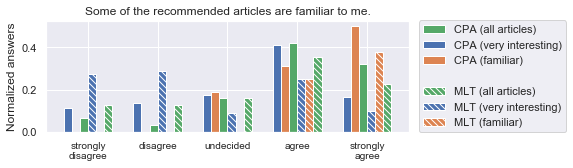

,-2,-1,0,1,2
CPA,9.0,11.0,14.0,33.0,13.0
MLT,22.0,23.0,7.0,20.0,8.0
CPA (very interesting seed),NaN,NaN,3.0,5.0,8.0
MLT (very interesting seed),NaN,NaN,0.0,4.0,6.0
CPA (familiar seed),2.0,1.0,5.0,13.0,10.0
MLT (familiar seed),4.0,4.0,5.0,11.0,7.0


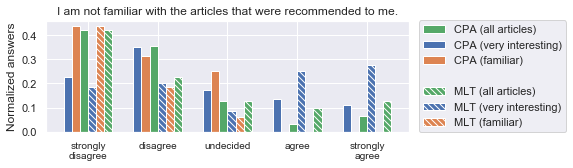

,-2,-1,0,1,2
CPA,18.0,28.0,14.0,11.0,9.0
MLT,15.0,16.0,7.0,20.0,22.0
CPA (very interesting seed),7.0,5.0,4.0,NaN,NaN
MLT (very interesting seed),7.0,3.0,1.0,NaN,NaN
CPA (familiar seed),13.0,11.0,4.0,1.0,2.0
MLT (familiar seed),13.0,7.0,4.0,3.0,4.0


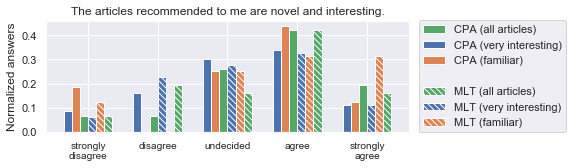

,-2,-1,0,1,2
CPA,7.0,13.0,24.0,27.0,9.0
MLT,5.0,18.0,22.0,26.0,9.0
CPA (very interesting seed),3.0,NaN,4.0,7.0,2.0
MLT (very interesting seed),2.0,NaN,4.0,5.0,5.0
CPA (familiar seed),2.0,2.0,8.0,13.0,6.0
MLT (familiar seed),2.0,6.0,5.0,13.0,5.0


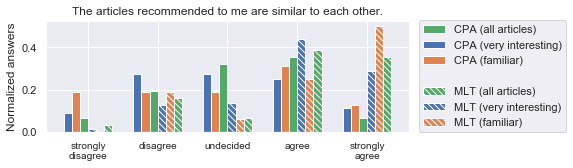

,-2,-1,0,1,2
CPA,7.0,22.0,22.0,20.0,9.0
MLT,1.0,10.0,11.0,35.0,23.0
CPA (very interesting seed),3.0,3.0,3.0,5.0,2.0
MLT (very interesting seed),0.0,3.0,1.0,4.0,8.0
CPA (familiar seed),2.0,6.0,10.0,11.0,2.0
MLT (familiar seed),1.0,5.0,2.0,12.0,11.0


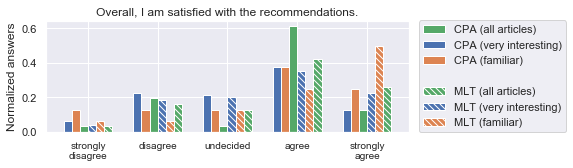

,-2,-1,0,1,2
CPA,5,18,17,30,10
MLT,3,15,16,28,18
CPA (very interesting seed),2,2,2,6,4
MLT (very interesting seed),1,1,2,4,8
CPA (familiar seed),1,6,1,19,4
MLT (familiar seed),1,5,4,13,8


In [12]:

def compare_with_subset2(df, selector, qs, qid, subset_label, selector2=None, subset_label2=None):

    mlt_qid = qid.replace('A', 'B')
    q_str = qs[qs['mc_qid'] == qid]['question'].values[0]
    
    assert df[mlt_qid].count() == df[mlt_qid].count()
    assert df[selector][mlt_qid].count() == df[selector][mlt_qid].count()
   
    graph_df = df[qid].value_counts().rename('CPA').to_frame()\
                   .join(df[mlt_qid].value_counts().rename('MLT').to_frame()).sort_index()

    dfs = df[selector]
    dfs2 = df[selector2]
    
    graph_df = dfs[qid].value_counts().rename('CPA').to_frame()\
                   .join(dfs[mlt_qid].value_counts().rename('MLT').to_frame()).sort_index()

    
    ### normalized + merge
    #fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
    
    full_df = df[qid].value_counts(normalize=True).rename('CPA').to_frame()\
                   .join(df[mlt_qid].value_counts(normalize=True).rename('MLT').to_frame()).sort_index().fillna(0)
    
    subset_df = dfs[qid].value_counts(normalize=True).rename(f'CPA ({subset_label})').to_frame()\
                   .join(dfs[mlt_qid].value_counts(normalize=True).rename(f'MLT ({subset_label})').to_frame()).sort_index().fillna(0)
    
    subset_df2 = dfs2[qid].value_counts(normalize=True).rename(f'CPA ({subset_label2})').to_frame()\
                   .join(dfs2[mlt_qid].value_counts(normalize=True).rename(f'MLT ({subset_label2})').to_frame()).sort_index().fillna(0)
    
    # 
    merged_abs_df = pd.concat([
        df[qid].value_counts().rename('CPA').to_frame()\
                   .join(df[mlt_qid].value_counts().rename('MLT').to_frame()).sort_index().fillna(0)
        ,
        dfs[qid].value_counts().rename(f'CPA ({subset_label})').to_frame()\
                   .join(dfs[mlt_qid].value_counts().rename(f'MLT ({subset_label})').to_frame()).sort_index().fillna(0)
        ,
        dfs2[qid].value_counts().rename(f'CPA ({subset_label2})').to_frame()\
                   .join(dfs2[mlt_qid].value_counts().rename(f'MLT ({subset_label2})').to_frame()).sort_index().fillna(0)
    
    ], axis=1, sort=False)
    
    # compute absolute difference
    try:
        cpa_dif = np.sum(np.abs(full_df[full_df.columns[0]].values - subset_df[subset_df.columns[0]].values))
        mlt_dif = np.sum(np.abs(full_df[full_df.columns[1]].values - subset_df[subset_df.columns[1]].values))
    except ValueError:
        cpa_dif = 0.
        mlt_dif = 0.
        
    dif_ = cpa_dif + mlt_dif
    dif = {
        'q': q_str,
        'subset': subset_label,        
        'dif': dif_,
        'mlt_dif': mlt_dif,
        'cpa_dif': cpa_dif,
    }

    merged_df = pd.concat([full_df, subset_df, subset_df2], axis=1, sort=False)
    merged_df = merged_df[[
        merged_df.columns[0], 
        merged_df.columns[2], 
        merged_df.columns[4], 
        
        merged_df.columns[1], 
        merged_df.columns[3],
        merged_df.columns[5],
        
    ]]

    fig = plt.figure(figsize=(9, 2.5))
    
    #plt.title(f'{q_str} (abs. difference: {dif_:.2})')
    plt.title(q_str)
    
    ax = merged_df.plot(
        #colormap='tab20',
        #color=['moccasin','orange','darkorange','lightblue','blue','darkblue'],
        color=[sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2]] * 2,
        kind='bar', 
        #fig, 
        #title=f'{q_str} (abs. difference: {dif_:.2})',
        ax=fig.gca(),
        width=0.7,
    )
    
    mlt_hatch = r'\\\\'
       
    hatches = [''] * int(len(ax.patches)/2) + [mlt_hatch] * int(len(ax.patches)/2)

    for bar, hatch in zip(ax.patches, hatches):
        bar.set_hatch(hatch)
    
    circs = []
    for i, v in enumerate(merged_df.columns):
        if 'MLT' in v:
            hatch = mlt_hatch
        else:
            hatch = None
        
        if 'interesting' in v:
            color = sns.color_palette()[0]
        elif 'familiar' in v:
            color = sns.color_palette()[1]
        else:
            color = sns.color_palette()[2]
            v += ' (all articles)'
        
        circs.append(mpatches.Patch(facecolor=color, hatch=hatch, label=v.replace(' seed', '')))
        
        if i == 2:
            circs.append(matplotlib.lines.Line2D([],[],linestyle=''))
            
    #for i, cat in enumerate(['Strongly disagree', 'Disagree','Undecided', 'Agree', 'Strongly agree']):
    #    circs.append(mpatches.Patch(facecolor=category_colors_a[i],hatch=r'\\\\',label=cat + ' (MLT)'))
    #for i, cat in enumerate(['Strongly disagree', 'Disagree','Undecided', 'Agree', 'Strongly agree']):
    #    circs.append(mpatches.Patch(facecolor=category_colors_a[i],label=cat + ' (CPA)'))
    plt.legend(handles=circs, ncol=1, loc='right', bbox_to_anchor=(1.45,0.5))

    #plt.legend([v.replace(' seed', '') for v in merged_df.columns], ncol=1, loc='right', bbox_to_anchor=(1.45,0.5))

    ax.set_ylabel('Normalized answers')
    ax.set_xticklabels([v.replace(' ', '\n') for v in get_value_mapping(qs, qid).values()], rotation=0, 
                       fontsize='small')   
    
    plt.tight_layout()
    #plt.savefig(f'./figures/two_subset_{qid}_{subset_label}_{subset_label2}.svg')
    plt.savefig(figures_dir + f'/two_subset_{qid}_{subset_label}_{subset_label2}.pdf')
    plt.show()    
    
    display(merged_abs_df.transpose())
    
    return full_df, subset_df, merged_df, dif


selector = df['MC2'] > 1
selector2 = df['MC1'] > 0 # MC1: How familiar with topic? -> Familiar with the article

difs = []

for qid in qs['mc_qid'].values:
    if ' A' in qid:
        full_df, subset_df, merged_df, dif = compare_with_subset2(df, selector, qs, qid, 'very interesting seed', selector2, 'familiar seed')
        difs.append(dif)
        
        
